### Federated Learning and Label Flipping attacks

In this notebook we train a machine learning model for MNIST classification.
We then train the same model in a federated learning setting.
In this setting, we test label flipping attacks and some defence mechanisms.

In [3]:
#IMPORTS
import sklearn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from scipy.spatial.distance import euclidean

import numpy as np
from sklearn.neural_network import MLPClassifier

import copy
from time import sleep
from tqdm import tqdm
import random

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

mnist = fetch_openml('mnist_784')
X = mnist.data.to_numpy()
y = mnist.target.to_numpy()

# Normalize X to 0..1
X = X / 255.0

In [5]:
X, X_public, y, y_public = train_test_split(X, y, test_size=0.05, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Testing a centralized model

We train a Scikit-learn multilayer perceptron to stablish a baseline
accuracy for our following experiments.

In [6]:
mlp = MLPClassifier(hidden_layer_sizes=(50,50,),
                    activation='relu',
                    solver='sgd',
                    batch_size=64,
                    learning_rate_init=0.001,
                    max_iter=100,
                    tol=0.0001,
                    shuffle=False,
                    verbose=True)
mlp.fit(X_train,y_train)

Iteration 1, loss = 1.11055291
Iteration 2, loss = 0.41721589
Iteration 3, loss = 0.34221428
Iteration 4, loss = 0.30741673
Iteration 5, loss = 0.28350132
Iteration 6, loss = 0.26499095
Iteration 7, loss = 0.24962104
Iteration 8, loss = 0.23637722
Iteration 9, loss = 0.22459483
Iteration 10, loss = 0.21390288
Iteration 11, loss = 0.20408664
Iteration 12, loss = 0.19503766
Iteration 13, loss = 0.18665446
Iteration 14, loss = 0.17898853
Iteration 15, loss = 0.17189867
Iteration 16, loss = 0.16534762
Iteration 17, loss = 0.15926354
Iteration 18, loss = 0.15358529
Iteration 19, loss = 0.14826147
Iteration 20, loss = 0.14331693
Iteration 21, loss = 0.13863297
Iteration 22, loss = 0.13424480
Iteration 23, loss = 0.13013080
Iteration 24, loss = 0.12623595
Iteration 25, loss = 0.12255077
Iteration 26, loss = 0.11905862
Iteration 27, loss = 0.11577397
Iteration 28, loss = 0.11266348
Iteration 29, loss = 0.10970015
Iteration 30, loss = 0.10688783
Iteration 31, loss = 0.10420212
Iteration 32, los

MLPClassifier(batch_size=64, hidden_layer_sizes=(50, 50), max_iter=100,
              shuffle=False, solver='sgd', verbose=True)

In [7]:
result = mlp.predict(X_test)
print('Accuracy :', accuracy_score(y_test,result))
print(classification_report(y_test,result))

Accuracy : 0.9718796992481203
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1285
           1       0.99      0.99      0.99      1482
           2       0.97      0.96      0.97      1340
           3       0.95      0.97      0.96      1312
           4       0.97      0.97      0.97      1369
           5       0.97      0.96      0.96      1165
           6       0.98      0.98      0.98      1313
           7       0.98      0.97      0.98      1372
           8       0.96      0.96      0.96      1321
           9       0.96      0.96      0.96      1341

    accuracy                           0.97     13300
   macro avg       0.97      0.97      0.97     13300
weighted avg       0.97      0.97      0.97     13300



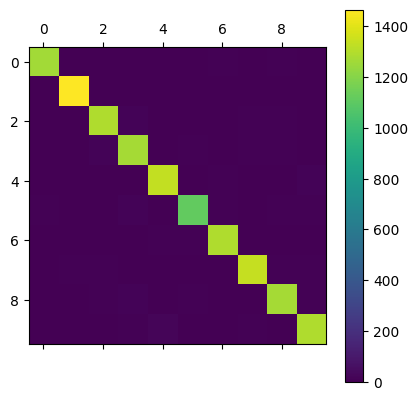

In [8]:
# BASELINE RESULTS
mat = confusion_matrix(y_test, mlp.predict(X_test))
plt.matshow(mat);
plt.colorbar()
plt.show()

Model definition to initialize the global model

In [9]:
# MODEL DEFINITION
def build_model(lr=0.001, batch_size=64, local_epochs=2, warm_start=True):
    model = MLPClassifier(hidden_layer_sizes=(50,50,),
                    activation='relu',
                    solver='sgd',
                    batch_size=batch_size,
                    learning_rate_init=lr,
                    max_iter=local_epochs,
                    early_stopping=False,
                    shuffle=False,
                    warm_start=warm_start,
                    tol=0.0001)

    return model

### Auxiliary methods for federated learning

The following functions are used to:
- get and set the NN's weights and biases,
- extract the users' local updates by substracting the local model parameters after training from the global model parameters, and
- to run a training step on the global model.

In [12]:
#AUXILIARY METHODS FOR FEDERATED LEARNING

# RETURN WEIGHTS AND BIASES OF A MODEL
def get_parameters(model):
    return copy.deepcopy(model.coefs_), copy.deepcopy(model.intercepts_)

# SET WEIGHTS AND BIASES OF A MODEL
def set_parameters(model, weights, biases):
    model.coefs_ = weights
    model.intercepts_ = biases

# RETURN THE DIFFERENCE OF MODELS' WEIGHTS AND BIASES AFTER AN UPDATE
# NOTE: LEARNING RATE IS APPLIED, SO THE UPDATE IS DIFFERENT FROM THE
# GRADIENTS. IN CASE VANILLA SGD IS USED, THE GRADIENTS ARE OBTAINED
# AS (UPDATES / LEARNING_RATE)
def get_updates(model, inputs, outputs, batch_size, epochs):
    w, b = get_parameters(model)
    model.fit(inputs, outputs)
    w_new, b_new = get_parameters(model)

    weight_updates = [old - new for old,new in zip(w, w_new)]
    bias_updates = [old - new for old,new in zip(b, b_new)]

    return weight_updates, bias_updates

# UPDATE THE MODEL'S WEIGHTS AND PARAMETERS WITH AN UPDATE
def apply_updates(model, eta, w_new, b_new):
    w, b = get_parameters(model)
    new_weights = [theta - eta*delta for theta,delta in zip(w, w_new)]
    new_biases = [theta - eta*delta for theta,delta in zip(b, b_new)]
    set_parameters(model, new_weights, new_biases)

# FEDERATED AGGREGATION FUNCTION
def aggregate(n_layers, n_peers, f, w_updates, b_updates):
    agg_w = [f([w_updates[j][i] for j in range(n_peers)], axis=0) for i in range(n_layers)]
    agg_b = [f([b_updates[j][i] for j in range(n_peers)], axis=0) for i in range(n_layers)]
    return agg_w, agg_b

# TRANSFORM ALL WEIGHT TENSORS TO 1D ARRAY
def flatten_weights(w_in):
    h = w_in[0].reshape(-1)
    for w in w_in[1:]:
        h = np.append(h, w.reshape(-1))
    return h

# TRANSFORM ALL BIAS TENSORS TO 1D ARRAY
def flatten_biases(b_in):
    h = b_in[0].reshape(-1)
    for b in b_in[1:]:
        h = np.append(h, b.reshape(-1))
    return h

# TRANSFORM WEIGHT AND BIAS TENSORS TO 1D ARRAY
def flatten_parameters(w_in, b_in):
    w = flatten_weights(w_in)
    b = flatten_biases(b_in)
    return w, b

# COMPUTE EUCLIDEAN DISTANCE OF WEIGHTS
def dist_weights(w_a, w_b):
    wf_a = flatten_weights(w_a)
    wf_b = flatten_weights(w_b)
    return euclidean(wf_a, wf_b)

# COMPUTE EUCLIDEAN DISTANCE OF BIASES
def dist_biases(b_a, b_b):
    bf_a = flatten_biases(b_a)
    bf_b = flatten_biases(b_b)
    return euclidean(bf_a, bf_b)

# COMPUTE EUCLIDEAN DISTANCE OF WEIGHTS AND BIASES
def dist_parameters(w_a, b_a, w_b, b_b):
    wf_a, bf_a = flatten_parameters(w_a, b_a)
    wf_b, bf_b = flatten_parameters(w_b, b_b)
    return euclidean(np.append(wf_a, bf_a), np.append(wf_b, bf_b))

### Auxiliary methods for attackers

The following to functions are used to:
- flip the labels from an origin class to a target class, and
- boost updates.

In [13]:
# AUXILIARY METHODS FOR THE ATTACKERS
def poison(labels, origin, target):
    output_cat = np.where(labels == origin, target, labels)
    output_cat[random.randint(0,len(labels))] = origin
    return output_cat

# MULTIPLIES PARAMETERS BY SOME SCALAR BOOST
def boosting(weights, biases, boost):
    w_boosted = [boost*w for w in weights]
    b_boosted = [boost*b for b in biases]
    return w_boosted, b_boosted

### Local training

The following function implements the local training at the clients' side. Clients can be either good or malicious. Good peers will just run a few local training steps and return the updates. Malicious clients will also poison their data before training, and optionally boost their updates before sending them.

In [14]:
# Client code
def client_training(global_model, local_batch_size, n_local_rounds, features, labels, malicious, malicious_targets, malicious_boost):

    # Fetch global model
    local_model = copy.deepcopy(global_model)

    # Local model update
    if malicious:
        # Malicious peer
        # Modify target class labels

        acts_mal = random.random() <= 1.0

        if acts_mal:
            labels = poison(labels, malicious_targets[i][0], malicious_targets[i][1])

        # Train local model with benign and malicious data
        local_weight_updates, local_bias_updates = get_updates(local_model,
                                                               features, labels,
                                                               local_batch_size, n_local_rounds)

        # Boost update
        if acts_mal:
            local_weight_updates, local_bias_updates = boosting(local_weight_updates, local_bias_updates, malicious_boost[i])

    else:
        # Benign peer
        # Train local model
        local_weight_updates, local_bias_updates = get_updates(local_model,
                                                               inputs, outputs,
                                                               local_batch_size, n_local_rounds)

    return local_weight_updates, local_bias_updates

## FL Testbed

### Test parameters

The following code contains the configuration of the FL tests.

The configuration includes:
- Number of peers
- Fraction of peers that participate in each of the global training epochs
- Number of global training epochs
- Number of local training epochs
- Batch size for local training
- Learning rate for local training
- Global training rate or model substitution rate
- Attack detection mechanism
    - None
    - Distance (with parameter tau)
    - Median
    - Krum (with parameter tolerance)

In [15]:
# TESTBED

#####################
# SYSTEM PARAMETERS #
#####################

# Number of peers
n_peers = 5

# Percentage and number of peers participating at each global training epoch
percentage_participants = 1.00
n_participants = int(n_peers * percentage_participants)

# Number of global training epochs
n_rounds = 10

# Number of local training epochs per global training epoch
n_local_rounds = 2

# Local batch size
local_batch_size = 32

# Local learning rate
local_lr = 0.001

# Global learning rate or 'gain'
model_substitution_rate = 0.25

# Attack detection / prevention mechanism = {None, 'distance', 'median', 'krum'}
discard_outliers = None

# Used in 'dist' attack detection, defines how far the outliers are (1.5 is a typical value)
tau = 1.5

# Used in 'krum' attack detection, defines how many byzantine attackers we want to defend against
tolerance=1


########################
# ATTACK CONFIGURATION #
########################

# Percentage of malicious peers
r_malicious_peers = 0.0

# Number of malicious peers (absolute or relative to total number of peers)
n_malicious_peers = int(n_peers * r_malicious_peers)

# Malicious peers
malicious_peer = [] # range(n_malicious_peers)

# Target for coalitions
common_attack_target = ['4','7']

# Target class of the attack, per each malicious peer
malicious_targets = dict([(p, t) for p,t in zip(malicious_peer, [common_attack_target]*n_malicious_peers)])

# Boosting parameter per each malicious peer
common_malicious_boost = 10
malicious_boost = dict([(p, b) for p,b in zip(malicious_peer, [common_malicious_boost]*n_malicious_peers)])

### Test execution

1. Global model initialization
2. Peer initialization
3. Training loop
    1. Selection of participating peers
    2. Local training
    3. Update collection
    4. Attack detection
    5. Parameter aggregation
    6. Report accuracy

In [16]:
####################################
# MODEL AND NETWORK INITIALIZATION #
####################################
global_model = build_model(local_lr, local_batch_size, n_local_rounds, True)

# In Scikit-learn, an initial fit is required to build initial weight
# and bias lists
global_model.fit(X_public, y_public)
n_layers = len(global_model.coefs_)


##################
# BEGIN TRAINING #
##################
for t in range(n_rounds):
    print(f'Round {t+1}.')
    #sleep(1)

    ## SERVER SIDE #################################################################

    # Initialize peer update lists
    network_weight_updates = []
    network_bias_updates = []

    # Selection of participant peers in this global training epoch
    participants = random.sample(list(range(n_peers)), n_participants)

    ################################################################################

    ## CLIENT SIDE #################################################################
    for i in tqdm(participants):

        # Initialization of user data
        ss = int(len(X_train)/n_peers)
        inputs = X_train[i*ss:i*ss+ss]
        outputs = y_train[i*ss:i*ss+ss]

        local_weight_updates, local_bias_updates = client_training(
            global_model,
            local_batch_size,
            n_local_rounds,
            inputs,
            outputs,
            i in malicious_peer,
            malicious_targets,
            malicious_boost
        )

        # Send updates to the server
        network_weight_updates.append(local_weight_updates)
        network_bias_updates.append(local_bias_updates)

    ## END OF CLIENT SIDE ##########################################################

    ######################################
    # SERVER SIDE AGGREGATION MECHANISMS #
    ######################################

    # No detection of outliers
    if discard_outliers == None:
        # Aggregate client updates
        aggregated_weights, aggregated_biases = aggregate(n_layers,
                                                          n_participants,
                                                          np.mean,
                                                          network_weight_updates,
                                                          network_bias_updates)

        # Apply updates to global model
        apply_updates(global_model, model_substitution_rate, aggregated_weights, aggregated_biases)

    # Detection of outliers via distance metric
    elif discard_outliers == 'distance':
        # Compute the provisional aggregate
        prov_agg_w, prov_agg_b = aggregate(n_layers,
                                           n_participants,
                                           np.mean,
                                           network_weight_updates,
                                           network_bias_updates)

        # Compute distances and IQR of individual updates to the provisional aggregate
        distances = [dist_weights(prov_agg_w, w_i) for w_i in network_weight_updates]
        q1 = np.percentile(distances, 25)
        q3 = np.percentile(distances, 75)
        iqr = q3 - q1
        low = q1 - tau * iqr
        high = q3 + tau * iqr

        # Discard outliers
        good_updates = [i for i,v in enumerate(distances) if low <= v <= high]
        agg_participants = len(good_updates)
        network_weight_updates = [w for i,w in enumerate(network_weight_updates) if i in good_updates]
        network_bias_updates = [b for i,b in enumerate(network_bias_updates) if i in good_updates]

        # Compute definitive update
        aggregated_weights, aggregated_biases = aggregate(n_layers,
                                                          agg_participants,
                                                          np.mean,
                                                          network_weight_updates,
                                                          network_bias_updates)

        # Apply update
        apply_updates(global_model, model_substitution_rate, aggregated_weights, aggregated_biases)


    # Robust aggregation via median
    elif discard_outliers == 'median':
        # Compute the aggregate as the component-wise median of local updates
        aggregated_weights, aggregated_biases = aggregate(n_layers,
                                                          n_participants,
                                                          np.median,
                                                          network_weight_updates,
                                                          network_bias_updates)

        # Apply update
        apply_updates(global_model, model_substitution_rate, aggregated_weights, aggregated_biases)

    # KRUM
    elif discard_outliers == 'krum':
        # First, we build a distance matrix for parameters
        P = list(zip(network_weight_updates, network_bias_updates))
        dist_matrix = [[dist_parameters(wi,bi,wj,bj) for wj,bj in P] for wi,bi in P]
        scores = []
        for index in range(len(P)):
            distances_to_index = np.array(dist_matrix[index])
            closest_to_index = np.argpartition(distances_to_index, n_participants-tolerance-1)[:n_participants-tolerance-1]
            scores.append(np.sum(distances_to_index[closest_to_index]))
        best = np.argmin(scores)
        aggregated_weights = network_weight_updates[best]
        aggregated_biases = network_bias_updates[best]

        # Apply update
        apply_updates(global_model, model_substitution_rate, aggregated_weights, aggregated_biases)

    # Fallback case: no detection of outliers
    else:
        # Proceed as in first case
        aggregated_weights, aggregated_biases = aggregate(n_layers,
                                                          n_participants,
                                                          np.mean,
                                                          network_weight_updates,
                                                          network_bias_updates)

        apply_updates(global_model, model_substitution_rate, aggregated_weights, aggregated_biases)

    ###################
    # COMPUTE METRICS #
    ###################

    # Global model accuracy
    result = global_model.predict(X_test)
    score = accuracy_score(y_test, result)
    print(f'Global model accuracy: {score}')


Round 1.


100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


Global model accuracy: 0.7604511278195488
Round 2.


100%|██████████| 5/5 [00:01<00:00,  2.92it/s]


Global model accuracy: 0.8127067669172933
Round 3.


100%|██████████| 5/5 [00:01<00:00,  2.84it/s]


Global model accuracy: 0.8445864661654136
Round 4.


100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


Global model accuracy: 0.8619548872180451
Round 5.


100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


Global model accuracy: 0.8746616541353384
Round 6.


100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


Global model accuracy: 0.8812781954887218
Round 7.


100%|██████████| 5/5 [00:01<00:00,  2.84it/s]


Global model accuracy: 0.8861654135338346
Round 8.


100%|██████████| 5/5 [00:01<00:00,  2.88it/s]


Global model accuracy: 0.8909774436090225
Round 9.


100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


Global model accuracy: 0.8947368421052632
Round 10.


100%|██████████| 5/5 [00:01<00:00,  2.67it/s]

Global model accuracy: 0.8976691729323308


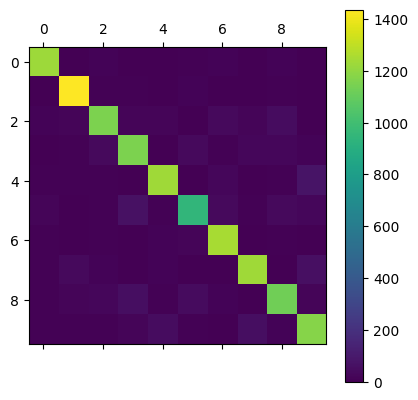

In [17]:
# BASELINE RESULTS
mat = confusion_matrix(y_test, global_model.predict(X_test))
plt.matshow(mat);
plt.colorbar()
plt.show()